# Bidisperse Colloidal Ice

In this notebook we will simulate a Bidisperse Colloidal Ice. The parameters that we will use are the ones theoretically calculated to obtein a full degenerate Colloidal Spin Ice.

    r1 = 1 um
    susceptibility1 = 0.5
    trap_sep1 = 23 um
    
and
    
    r2 = 1 um
    susceptibility2 = 0.0675
    trap_sep2 = 30.3558 um
    
    
On the other hand the values of the field will be 25 mT and the total time 900 s. 

In [5]:
import sys
import os
import shutil
sys.path.insert(0, 'icenumerics/')

import pandas as pd
import numpy as np
import scipy.spatial as spa
import matplotlib.pyplot as plt
import matplotlib as mpl

import icenumerics as ice
from icenumerics.geometry import ordering 
import csv as csv
import time
import string as st
from multiprocessing import Pool

import copy as cp

ureg = ice.ureg

idx = pd.IndexSlice

import tqdm.auto as tqdm

%reload_ext autoreload
%autoreload 2

In [6]:
directory = "/home/carolina/Output_Sim_Summer_2020"
directory_DataFrame = "/home/carolina/DataFrames_Summer_2020"

# Design of the program for parallel preocesses

In [7]:
def do_everything(exp_entry):
    e = exp_entry[1].e 
    l = exp_entry[1].l
    
    
    # <To change the seed of the thermal noise>
    
    np.random.seed()
    
    # <Introduce the parameters for the simulation>

    lattice_constant = 33*ureg.um
    lattic_size = [l,l]
    sp = ice.spins()
    sp.create_lattice("square",[l,l],lattice_constant=33*ureg.um, border="periodic")
    sp.order_spins(ordering.random_ordering)

    particle1 = ice.particle(radius = 1*ureg.um,
             susceptibility = 0.5,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

    trap1 = ice.trap(trap_sep = 23*ureg.um,
                   height = 0.5*ureg.pN*ureg.nm,
                   stiffness = 6e-4*ureg.pN/ureg.nm)

    particle2 = ice.particle(radius = 1*ureg.um,
             susceptibility = 0.0675,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

    trap2 = ice.trap(trap_sep = 30.3558*ureg.um,
                   height = 0.5*ureg.pN*ureg.nm,
                   stiffness = 6e-4*ureg.pN/ureg.nm)

    # <In this loop we are generating our bidisperse Ice>
    
    traps = []
    particles = []

    for s in sp:

        if s.direction[1] == 0:
            # Horizontal traps
            traps.append(trap1) 
            particles.append(particle1)
            pass

        else: 
            # Vertical traps
            traps.append(trap2) 
            particles.append(particle2) 


    col = ice.colloidal_ice(sp, particles, traps , height_spread = 0.1 , susceptibility_spread = 0)
#     col.display()
    
    # <Make the system periodic>
    
    col.region[:,:2]=(np.array([np.array([0,0]),lattic_size])-0.1)*lattice_constant
    col.region[:,2] = np.array([-.11,.11])*ureg.um
    
    # <Introduce the simulation parameters>
    
    world = ice.world(
    field = 300*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um,
    boundaries = ["p", "p", "p"])

    total_time = 300*ureg.s
    col.simulation(world,
                 name = "BidisperseColloidalIce_300mT-300s_l%u_exp%u"%(l,e),
                 include_timestamp = False,
                 targetdir = directory,
                 framerate = 1*ureg.Hz,
                 timestep = 10*ureg.ms,
                 run_time = total_time,
                 output = ["x","y","z","mux","muy","muz"])

    col.sim.field.fieldz = "v_Bmag*time/%f"%total_time.to(ureg.us).magnitude
    col.run_simulation()
    
    # <Load simulation and compute vertices dataframes>
    
    col.load_simulation(slice(0,None,15))
    
    v = ice.vertices()
    frames = col.trj.index.get_level_values("frame").unique()

    v_df = []

    for f in tqdm.tqdm(frames[::1]):
        col.set_state_from_frame(f)
        v = v.colloids_to_vertices(col)

        v_df.append(v.DataFrame())

    v_df = pd.concat(v_df, keys=frames[::1], names = ["frame"])
    
    # <Save the dataframe and create index of the runned simulation>
    
    v_df.to_csv(os.path.join(directory_DataFrame,"BidisperseColloidalIce_300mT-300s_l%u_exp%u"%(l,e)+".dat"), sep='\t')
    
    name = os.path.split(col.sim.base_name)[1]
    with open(os.path.join(directory,"index_Bidisperse.dat"),'a',newline='') as file:
        writer = csv.writer(file,delimiter='\t')
        writer.writerow([name, l, e])

In [8]:
300/300

1.0

In [9]:
e =  np.arange(0,10)
l =  np.arange(22,23)
L, E = np.meshgrid(l,e)
experiments = pd.DataFrame({"e":E.flatten(),"l":L.flatten()})

In [10]:
# %%time
if __name__ ==  '__main__': 
    num_processors = 6
    p=Pool(processes = num_processors)
    
    ## Create index text file
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(os.path.join(directory,"index_Bidisperse.dat"),'w',newline='') as file:
        writer = csv.writer(file,delimiter='\t')
        writer.writerow(["filename", "l", "exp"])
        
    list(tqdm.tqdm(p.imap(do_everything, experiments.iterrows()), total=len(experiments)))

--- Logging error ---
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 528, in get
    value = obj._trait_values[self.name]
KeyError: 'layout'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carolina/anaconda3/lib/python3.7

--- Logging error ---
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 528, in get
    value = obj._trait_values[self.name]
KeyError: 'layout'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carolina/anaconda3/lib/python3.7

--- Logging error ---
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 528, in get
    value = obj._trait_values[self.name]
KeyError: 'layout'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carolina/anaconda3/lib/python3.7

--- Logging error ---
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 528, in get
    value = obj._trait_values[self.name]
KeyError: 'layout'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carolina/anaconda3/lib/python3.7

--- Logging error ---
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 528, in get
    value = obj._trait_values[self.name]
KeyError: 'layout'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carolina/anaconda3/lib/python3.7

--- Logging error ---
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 528, in get
    value = obj._trait_values[self.name]
KeyError: 'layout'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carolina/anaconda3/lib/python3.7

# Design of the program for no parallel computation

### Simulation parameters

[-33.0 -0.0 -0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer
[33.0 0.0 0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer
[33.0 0.0 0.0] micrometer
[33.0 0.0 0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer
[33.0 0.0 0.0] micrometer


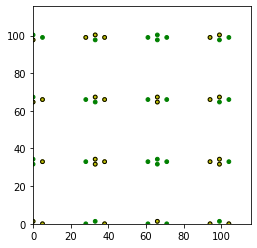

In [2]:
e = 1
l = 4

lattice_constant = 33*ureg.um
lattic_size = [l,l]
sp = ice.spins()
sp.create_lattice("square",[l,l],lattice_constant=33*ureg.um, border="periodic")
sp.order_spins(ordering.random_ordering)

sp.lattice
particle1 = ice.particle(radius = 1*ureg.um,
         susceptibility = 0.5,
         diffusion = 0.125*ureg.um**2/ureg.s,
         temperature = 300*ureg.K,
         density = 1000*ureg.kg/ureg.m**3)

trap1 = ice.trap(trap_sep = 23*ureg.um,
               height = 0.5*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

particle2 = ice.particle(radius = 1*ureg.um,
         susceptibility = 0.0675,
         diffusion = 0.125*ureg.um**2/ureg.s,
         temperature = 300*ureg.K,
         density = 1000*ureg.kg/ureg.m**3)

trap2 = ice.trap(trap_sep = 30.3558*ureg.um,
               height = 0.5*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

# <In this loop we are generating our bidisperse Ice>

traps = []
particles = []

for s in sp:

    if s.direction[1] == 0:
        print(s.direction)
        # Horizontal traps
        traps.append(trap1) 
        particles.append(particle1)
        pass

    else: 
        # Vertical traps
        traps.append(trap2) 
        particles.append(particle2) 


col = ice.colloidal_ice(sp, particles, traps , height_spread = 0.20 , susceptibility_spread = 0)
col.display()

In [3]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

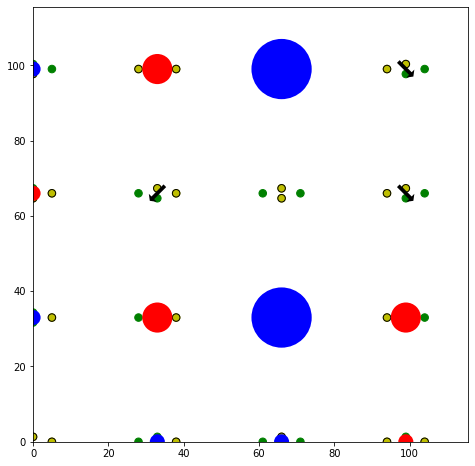

In [4]:

f, (ax1) = plt.subplots(1,1,figsize = (8,8))


col.display(ax1)
v.display(ax1)



In [5]:
col.region[:,:2]=(np.array([np.array([0,0]),lattic_size])-0.1)*lattice_constant
col.region[:,2] = np.array([-.11,.11])*ureg.um

world = ice.world(
    field = 30*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um,
    boundaries = ["p", "p", "p"])

total_time = 100*ureg.s
col.simulation(world,
             name = "execute_test_l%u_exp%u"%(l,e),
             include_timestamp = False,
             targetdir = r".",
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

col.sim.field.fieldz = "v_Bmag*time/%f"%total_time.to(ureg.us).magnitude
col.run_simulation()

In [6]:
col.load_simulation(slice(0,None,15))


In [7]:
col.trj

type             x          y    z   mux  muy  muz     t
frame id                                                          
0     1      1  8.095530e-17   1.322100  0.0   0.0  0.0  0.0   0.0
      2      1  3.300000e+01  31.677900  0.0   0.0  0.0  0.0   0.0
      3      1  6.600000e+01   1.322100  0.0   0.0  0.0  0.0   0.0
      4      1  9.900000e+01  31.677900  0.0   0.0  0.0  0.0   0.0
      5      1  1.939710e-15  64.677902  0.0   0.0  0.0  0.0   0.0
...        ...           ...        ...  ...   ...  ...  ...   ...
6     60     4  1.155000e+02  66.000000  0.0  23.0  0.0  0.0  90.0
      61     4  1.650000e+01  99.000000  0.0  23.0  0.0  0.0  90.0
      62     4  4.950000e+01  99.000000  0.0 -23.0 -0.0 -0.0  90.0
      63     4  8.250000e+01  99.000000  0.0  23.0  0.0  0.0  90.0
      64     4  1.155000e+02  99.000000  0.0  23.0  0.0  0.0  90.0

[448 rows x 8 columns]

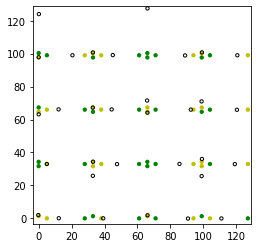

In [8]:
col.display()

In [9]:
trj_particle = col.trj[col.trj.type<=2]

In [10]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 70

In [11]:
# frame = 50

# plt.plot(trj_particle.loc[idx[frame,:],"x"],trj_particle.loc[idx[frame,:],"y"],'.')
# plt.axis("square");

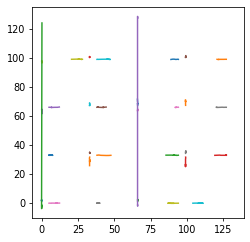

In [12]:
for i in trj_particle.index.get_level_values("id").unique():
    plt.plot(trj_particle.loc[idx[:,i],"x"],trj_particle.loc[idx[:,i],"y"])
plt.axis("square");

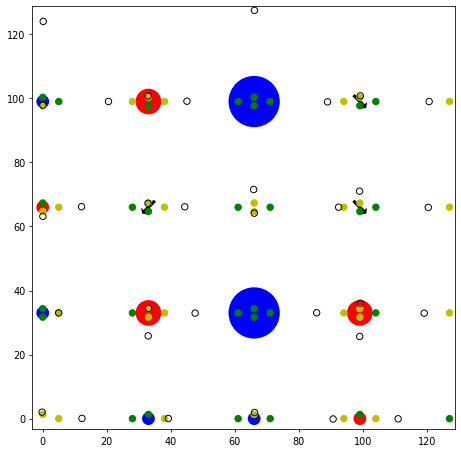

In [13]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))
v.display(ax1)
col.display(ax1)




In [14]:
v = v.colloids_to_vertices(col)

In [15]:
v.spins['Direction']

array([[-1.000000e+00, -0.000000e+00],
       [-1.000000e+00, -0.000000e+00],
       [ 1.000000e+00,  0.000000e+00],
       [-1.000000e+00, -0.000000e+00],
       [-1.000000e+00, -0.000000e+00],
       [-1.000000e+00, -0.000000e+00],
       [ 1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  0.000000e+00],
       [-1.000000e+00, -0.000000e+00],
       [-1.000000e+00, -0.000000e+00],
       [ 1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  0.000000e+00],
       [-1.000000e+00, -0.000000e+00],
       [ 1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  0.000000e+00],
       [-6.123234e-17, -1.000000e+00],
       [ 6.123234e-17,  1.000000e+00],
       [-6.123234e-17, -1.000000e+00],
       [ 6.123234e-17,  1.000000e+00],
       [ 6.123234e-17,  1.000000e+00],
       [-6.123234e-17, -1.000000e+00],
       [ 6.123234e-17,  1.000000e+00],
       [-6.123234e-17, -1.000000e+00],
       [ 6.123234e-17,  1.000000e+00],
       [-6.123234e-17, -1

In [16]:
v.neighbors

{0: {8, 20, 24},
 1: {12, 13, 25, 29},
 2: {12, 24, 28},
 3: {4, 16, 20},
 4: {8, 9, 21, 25},
 5: {2, 3, 19},
 6: {10, 11, 23, 27},
 7: {6, 7, 19, 23},
 8: {9, 10, 22, 26},
 9: {14, 15, 27, 31},
 10: {13, 14, 26, 30},
 11: {0, 1, 17},
 12: {1, 2, 18},
 13: {5, 6, 18, 22},
 14: {4, 5, 17, 21}}

In [17]:
v.DataFrame()

,Coordination,Charge,DipoleX,DipoleY,LocationX,LocationY
id,,,,,,
0,3,1,-1.000000e+00,2.0,0.0,66.0
1,4,2,-6.123234e-17,-2.0,33.0,99.0
2,3,-1,1.000000e+00,2.0,0.0,99.0
3,3,-1,-1.000000e+00,0.0,0.0,33.0
4,4,0,-2.000000e+00,-2.0,33.0,66.0
5,3,1,6.123234e-17,1.0,99.0,0.0
6,4,0,2.000000e+00,-2.0,99.0,66.0
7,4,2,2.000000e+00,0.0,99.0,33.0
8,4,0,6.123234e-17,0.0,66.0,66.0


In [18]:
# frames = col.trj.index.get_level_values("frame").unique()

# v_df = []

# for f in tqdm.tqdm(frames[::1]):
#     col.set_state_from_frame(f)
#     v = v.colloids_to_vertices(col)

#     v_df.append(v.DataFrame())

# v_df = pd.concat(v_df, keys=frames[::1], names = ["frame"])

In [17]:
# col.display()

In [18]:
# col.trj

In [19]:

# f, (ax1) = plt.subplots(1,1,figsize = (8,8))

# v.display(ax1)
# col.display(ax1)

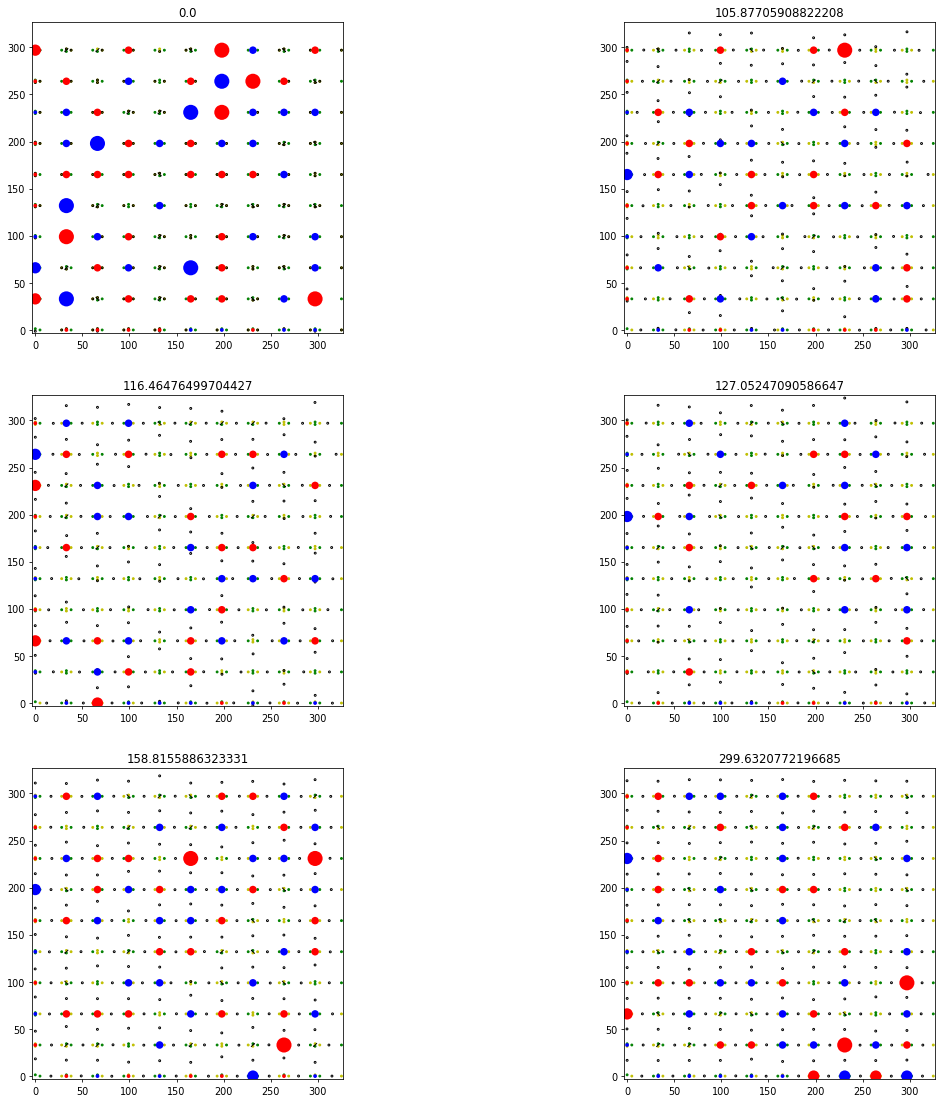

In [20]:
f, axes = plt.subplots(3,2,figsize = (20,20))
ax1, ax2, ax3, ax4, ax5,ax6 = axes.flatten()
i = 10
col.set_state_from_frame(0)
v = v.colloids_to_vertices(col)
field = 0/0.06667*300/8500
ax1.set_title(str(field))
col.display(ax1)
v.display(ax1)
col.set_state_from_frame(200)
v = v.colloids_to_vertices(col)
field1 = 200/0.06667*300/8500
ax2.set_title(str(field1))
col.display(ax2)
v.display(ax2)
col.set_state_from_frame(220)
v = v.colloids_to_vertices(col)
field2 = 220/0.06667*300/8500
ax3.set_title(str(field2))
col.display(ax3)
v.display(ax3)
col.set_state_from_frame(240)
v = v.colloids_to_vertices(col)
field3 = 240/0.06667*300/8500
ax4.set_title(str(field3))
col.display(ax4)
v.display(ax4)
col.set_state_from_frame(300)
v = v.colloids_to_vertices(col)
field4 = 300/0.06667*300/8500
ax5.set_title(str(field4))
col.display(ax5)
v.display(ax5)
col.set_state_from_frame(566)
v = v.colloids_to_vertices(col)                                
field5 = 566/0.06667*300/8500
ax6.set_title(str(field5))
col.display(ax6)
v.display(ax6)